In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline

In [3]:
df = pd.read_csv('IRIS.csv')

In [4]:
df['values'] = pd.factorize(df['species'])[0]

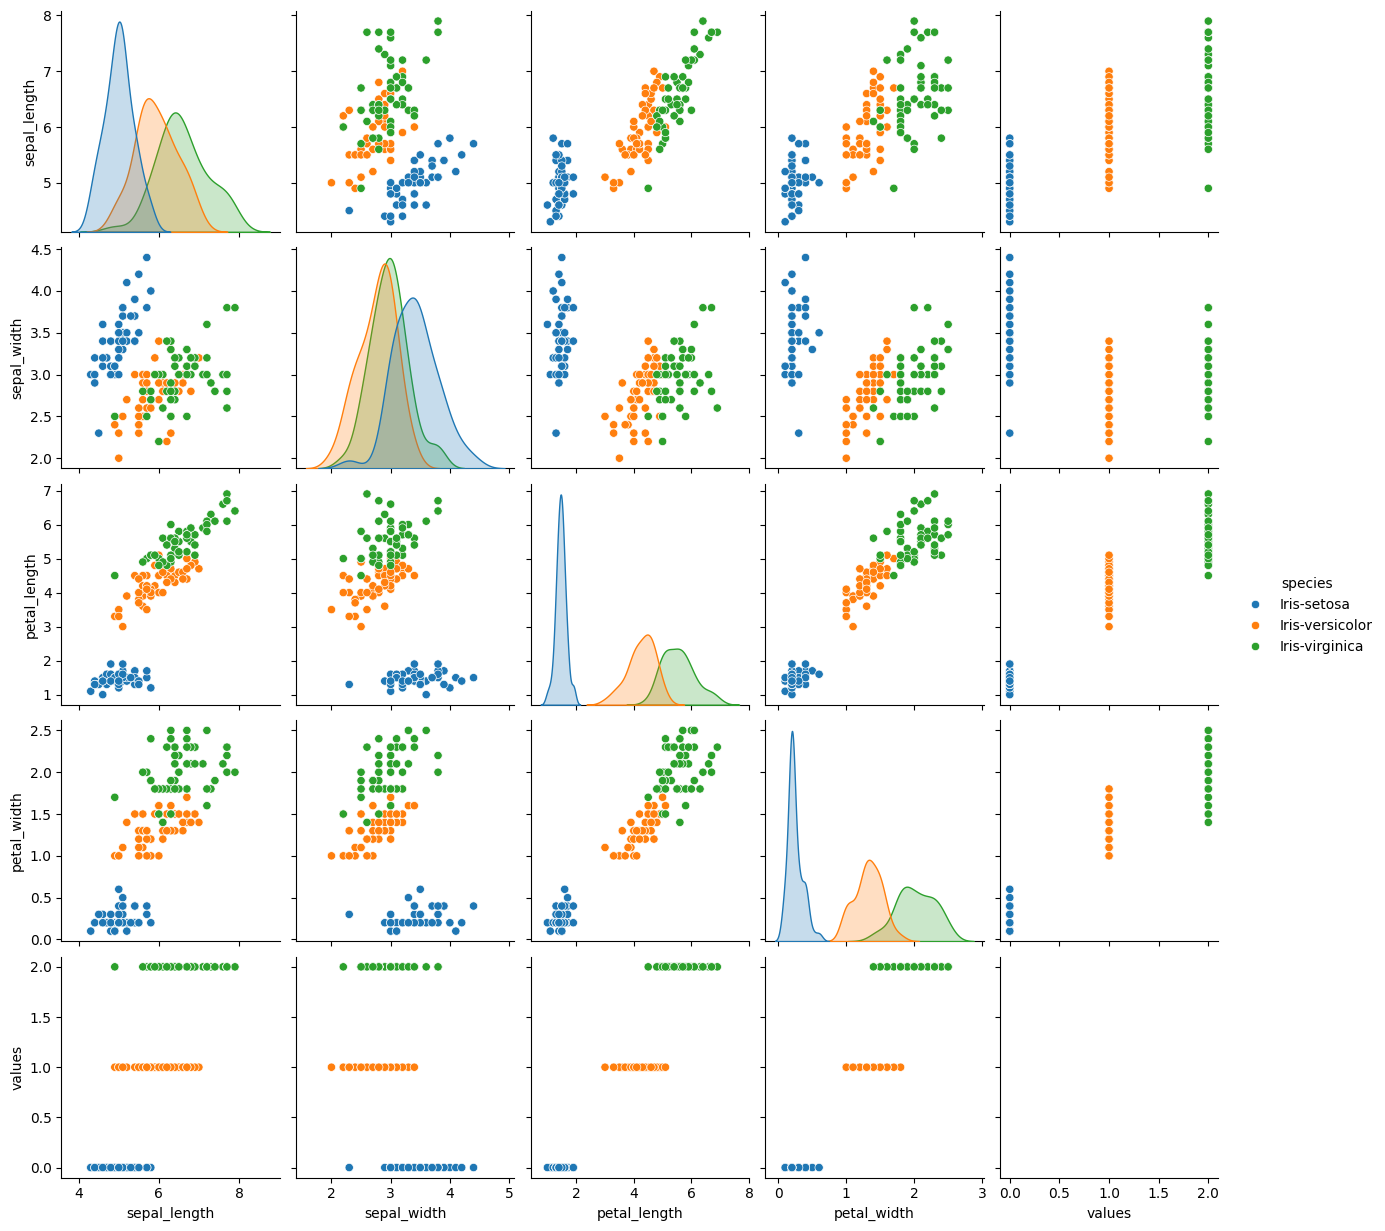

In [5]:
sns.pairplot(df, hue='species')

In [6]:
# shuffle to prevent overfitting
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [7]:
split = int(df.shape[0] * 0.75)
train = df[:split]
test = df[split:]
train.head()

,sepal_length,sepal_width,petal_length,petal_width,species,values
0,6.1,2.8,4.7,1.2,Iris-versicolor,1
1,5.7,3.8,1.7,0.3,Iris-setosa,0
2,7.7,2.6,6.9,2.3,Iris-virginica,2
3,6.0,2.9,4.5,1.5,Iris-versicolor,1
4,6.8,2.8,4.8,1.4,Iris-versicolor,1


In [8]:
X_train = train.drop(columns=['values', 'species']).values
Y_train = train['values'].values
X_test = test.drop(columns=['values', 'species']).values
Y_test = test['values'].values

In [9]:
def manual_train_single_feature(petal_length):
    if petal_length < 2.5:
        return 0
    elif petal_length < 4.0: 
        return 1
    else:
        return 2

In [10]:
manual_y_predictions = np.array([manual_train_single_feature(val) for val in X_train[:, 2]])

In [11]:
print(np.mean(manual_y_predictions == Y_train))

0.7589285714285714


In [12]:
SKY_train = train['species'].values #scikit-learn takes a 1d array as an output
SKY_test = test['species'].values

from sklearn.svm import SVC
model_svc = SVC()
model_svc.fit(X_train, SKY_train)
svc_results = model_svc.predict(X_test)
print(np.mean(svc_results == SKY_test))

0.9736842105263158


In [13]:
class SVM():
    def __init__(self, learning_rate=0.001, lambda_param=0.01, n_iters=300):
        self.lr = learning_rate
        self.lambda_param = lambda_param
        self.n_iters = n_iters
        self.classes = None
        self.models = {}
        
    def fit(self, X, Y):
        self.classes = np.unique(Y)
        n_samples, n_features = X.shape
        
        for c in self.classes:
            y_binary = np.where(Y == c, 1, -1)
            w = np.random.rand(n_features) * 0.01
            b = 0
            
            for _ in range(self.n_iters):
                for idx, x_i in enumerate(X):
                    condition = y_binary[idx] * (np.dot(x_i, w) - b) >= 1
                    if condition:
                        w -= self.lr * (2 * self.lambda_param * w)
                    else:
                        w -= self.lr * (2 * self.lambda_param * w - np.dot(y_binary[idx], x_i))
                        b -= self.lr * y_binary[idx]
            
            self.models[c] = (w, b) 
            
    def predict(self, X):
        scores = {c: np.dot(X, w) - b for c, (w, b) in self.models.items()}
        predictions= np.array([max(scores, key=lambda c: scores[c][i]) for i in range(X.shape[0])])
        return predictions

In [14]:
model_customsvc = SVM()
model_customsvc.fit(X_train, Y_train)
Y_pred = model_customsvc.predict(X_test)
print(np.mean(Y_pred == Y_test))

0.9473684210526315


In [15]:
from sklearn.linear_model import LogisticRegression
model_lr = LogisticRegression()
model_lr.fit(X_train, SKY_train)
lr_results = model_lr.predict(X_test)
print(np.mean(lr_results == SKY_test))

0.9736842105263158


In [16]:
def softmax(x):
    exp_values = np.exp(x - np.max(x, axis=1, keepdims=True))
    return exp_values / np.sum(exp_values, axis=1, keepdims=True)

class MCLogisticRegression():
    def __init__(self, learning_rate=0.001, n_iters=5000):
        self.lr = learning_rate
        self.n_iters = n_iters
        self.classes = {}
        self.w = None
        self.b = None
        
    def fit(self, X, Y):
        n_samples, n_features = X.shape
        self.classes = np.unique(Y)
        n_classes = len(self.classes)
        self.w = np.random.randn(n_features, n_classes) * 0.01
        self.b = np.zeros(n_classes)
        
        Y_one_hot = np.eye(n_classes)[Y]
        
        for _ in range(self.n_iters):
            linear_pred = np.dot(X, self.w) + self.b
            pred = softmax(linear_pred)
            
            dw = (1/n_samples) * np.dot(X.T, (pred - Y_one_hot))
            db = (1/n_samples) * np.sum(pred - Y_one_hot, axis=0)
            
            self.w -= self.lr * dw
            self.b -= self.lr * db
            
    def predict(self, X):
        linear_pred = np.dot(X, self.w) + self.b
        pred = softmax(linear_pred)
        return np.argmax(pred, axis=1)


In [17]:
model_customsvc = MCLogisticRegression()
model_customsvc.fit(X_train, Y_train)
Y_pred = model_customsvc.predict(X_test)
print(np.mean(Y_pred == Y_test))

0.9736842105263158


In [18]:
from sklearn.tree import DecisionTreeClassifier
model_dtc = DecisionTreeClassifier()
model_dtc.fit(X_train, SKY_train)
dtc_results = model_dtc.predict(X_test)
print(np.mean(dtc_results == SKY_test))

0.9473684210526315


In [19]:
class Node():
    def __init__(self, feature_index=None, threshold=None, left=None, right=None, info_gain=None, value=None):
       
        #decision node
        self.feature_index = feature_index
        self.threshold = threshold
        
        #left and right children
        self.left = left
        self.right = right
        
        #stored info gained from split
        self.info_gain = info_gain
        
        #leaf node
        self.value = value
        
class DecisionTree():
    def __init__(self, min_samples_split=2, max_depth=None):
        
        #initialize tree
        self.root = None
        
        #stopping conditions
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        
    def build_tree(self, dataset, curr_depth=0):
        X, Y = dataset[:,:-1], dataset[:, -1]
        num_samples, num_features = np.shape(X)
        
        if num_samples >= self.min_samples_split and (self.max_depth is None or curr_depth <= self.max_depth):
            best_split = self.get_best_split(dataset, num_samples, num_features)
            if best_split['info_gain'] > 0:
                left_subtree = self.build_tree(best_split['dataset_left'], curr_depth+1)
                right_subtree = self.build_tree(best_split['dataset_right'], curr_depth+1)
                
                return Node(best_split['feature_index'], best_split['threshold'], left_subtree, right_subtree, best_split['info_gain'])
        
        leaf_value = self.calculate_leaf_value(Y)
        return Node(value=leaf_value)
    
    def get_best_split(self, dataset, num_samples, num_features):
        best_split = {}
        max_info_gain = -float('inf')
        
        for feature_index in range(num_features):
            feature_values = dataset[:, feature_index]
            possible_thresholds = np.unique(feature_values)
            
            for threshold in possible_thresholds:
                dataset_left, dataset_right = self.split(dataset, feature_index, threshold)
                if len(dataset_left) > 0 and len(dataset_right) > 0:
                    y, left_y, right_y = dataset[:, -1], dataset_left[:, -1], dataset_right[:, -1]
                    curr_info_gain = self.information_gain(y, left_y, right_y, 'gini')
                    if curr_info_gain > max_info_gain:
                        best_split['feature_index'] = feature_index
                        best_split['threshold'] = threshold
                        best_split['dataset_left'] = dataset_left
                        best_split['dataset_right'] = dataset_right
                        best_split['info_gain'] = curr_info_gain
                        max_info_gain = curr_info_gain
                        
        return best_split
    
    def split(self, dataset, feature_index, threshold):
        dataset_left = np.array([row for row in dataset if row[feature_index] <= threshold])
        dataset_right = np.array([row for row in dataset if row[feature_index] > threshold])
        return dataset_left, dataset_right
    
    def information_gain(self, parent, l_child, r_child, mode='entropy'):
        weight_l = len(l_child) / len(parent)
        weight_r = len(r_child) / len(parent)
        if mode == 'gini':
            gain = self.gini_index(parent) - (weight_l * self.gini_index(l_child) + weight_r * self.gini_index(r_child))
        elif mode == 'entropy':
            gain = self.entropy(parent) - (weight_l * self.entropy(l_child) + weight_r * self.entropy(r_child))
            
        return gain
    
    def gini_index(self, y):
        class_labels = np.unique(y)
        gini = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            gini += p_cls**2
            
        return 1 - gini
    
    def entropy(self, y):
        class_labels = np.unique(y)
        ent = 0
        for cls in class_labels:
            p_cls = len(y[y == cls]) / len(y)
            ent += -p_cls * np.log2(p_cls)
            
        return ent
    
    def calculate_leaf_value(self, Y):
        Y = list(Y)
        return max(Y, key=Y.count)
    
    def fit(self, X, Y):
        Y = Y.reshape(-1, 1)
        dataset = np.concatenate((X, Y), axis=1)
        self.root = self.build_tree(dataset)
        
    def predict(self, X):
        predictions = [self.make_predictions(x, self.root) for x in X]
        return predictions
    
    def make_predictions(self, x, tree):
        if tree.value != None: return tree.value
        feature_val = x[tree.feature_index]
        if feature_val <= tree.threshold:
            return self.make_predictions(x, tree.left)
        else:
            return self.make_predictions(x, tree.right)

In [20]:
model_customdtc = DecisionTree()
model_customdtc.fit(X_train, Y_train)
Y_pred = model_customdtc.predict(X_test)
print(np.mean(Y_pred == Y_test))

0.9473684210526315
